# In-Depth: Support Vector Machines

Support vector machines (SVMs) are a particularly powerful and flexible class of supervised algorithms for both classification and regression.
In this section, we will develop the intuition behind support vector machines and their use in classification problems.

We begin with the standard imports:

In [1]:
import pandas as pd, numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import combinations
from scipy import stats
from ipywidgets import interact, fixed
import math

# Adding fonts
from matplotlib import font_manager
paths = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
for font_path in paths:
    if font_path.find("Hiragino Sans GB W3")>-1: break

font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':prop.get_name()})
plt.rc('axes', unicode_minus=False)

## Support Vector Machines

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

In [2]:
def plot_scatter(X, y):
    
    ax = plt.subplots(figsize=(6,4.5))[1]
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap="winter", edgecolor="k")    
    ax.patch.set_alpha(0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', labelsize=11)
    plt.tight_layout()
    return ax

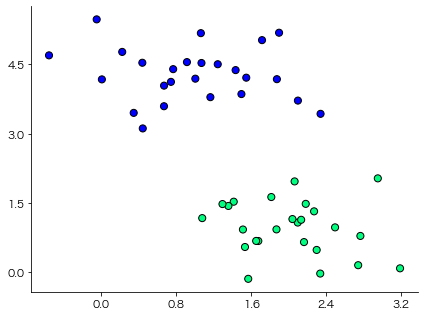

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
ax = plot_scatter(X, y)

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification.
For two dimensional data like that shown here, this is a task we could do by hand.
But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

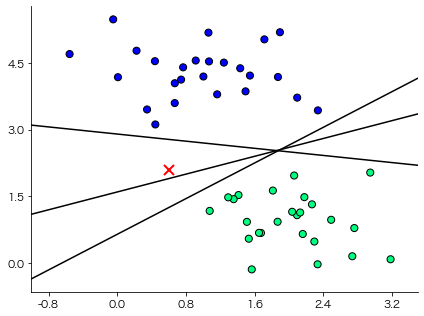

In [4]:
xfit = np.linspace(-1, 3.5)
ax = plot_scatter(X, y)
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.tight_layout()

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

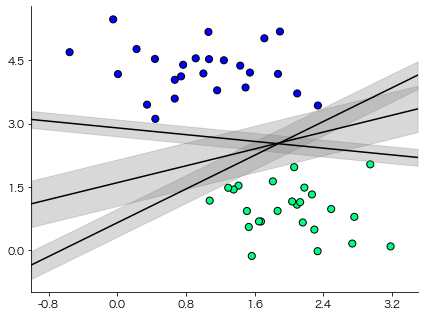

In [5]:
xfit = np.linspace(-1, 3.5)
ax = plot_scatter(X, y)

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, 
                     edgecolor='none',color='grey', alpha=0.3)
plt.xlim(-1, 3.5)
plt.tight_layout()

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [6]:
from sklearn.svm import SVC, OneClassSVM # "Support vector classifier"
model = SVC(kernel='linear', C=1E10).fit(X, y)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [7]:
def plot_svc_decision_function(model, ax, plot_vectors=True):
    """Plot the decision function for a 2D SVC"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_vectors:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none',
                   edgecolor="k")
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.patch.set_alpha(0)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis='both', labelsize=11)

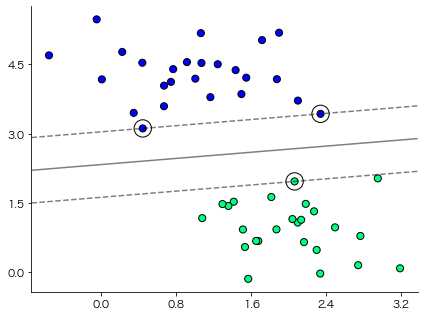

In [8]:
ax = plot_scatter(X, y)
plot_svc_decision_function(model, ax)
plt.tight_layout()

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are indicated by the black circles in this figure.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

In [27]:
def plot_svm(N=10, ax=None):
    
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    if ax is None: ax = plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter', ec='k')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

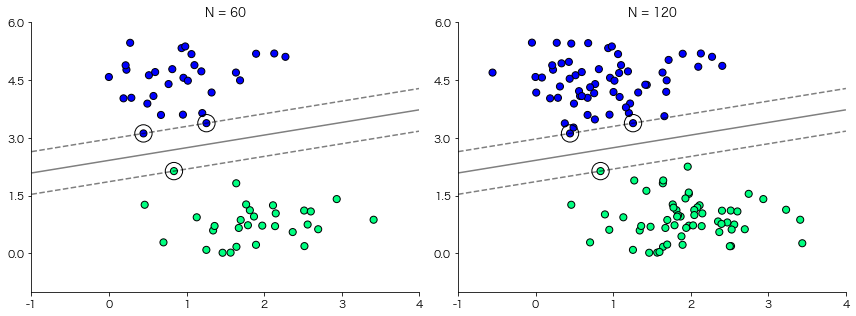

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))
plt.tight_layout()

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

If you are running this notebook live, you can use IPython's interactive widgets to view this feature of the SVM model interactively:

In [29]:
interact(plot_svm, N=[10, 100, 200], ax=fixed(None))
plt.tight_layout()

interactive(children=(Dropdown(description='N', options=(10, 100, 200), value=10), Output()), _dom_classes=('w…

<Figure size 432x288 with 0 Axes>

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
We have seen a version of kernels before, in the basis function regressions
There we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

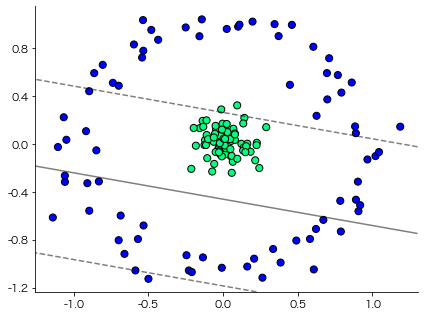

In [30]:
from sklearn.datasets import make_circles
X, y = make_circles(150, factor=.1, noise=.1, random_state=0)

clf = SVC(kernel='linear').fit(X, y)
ax = plt.subplots(figsize=(6,4.5))[1]
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter', ec='k')
plot_svc_decision_function(clf, ax, False)
plt.tight_layout()

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions, and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [31]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot—if you are running this notebook live, you will be able to use the sliders to rotate the plot:

In [32]:
def sort_vectors(xy):
    
    # Center all vectors
    ctr_xy = xy - np.mean(xy,0)
    ref = np.r_[[1,0]]

    # Compute angles wrt. horizontal line (x)
    a = pow((ctr_xy**2).sum(axis=1),0.5)
    b = pow(sum(pow(ref,2)),0.5)
    angles = np.r_[[math.acos(t)*180/np.pi 
                    for t in ref.dot(ctr_xy.T)/(a*b)]]
    angles = np.where(ctr_xy[:,1]<0,360-angles,angles)
    sort_index = np.argsort(angles)  
    
    return np.r_[sort_index,sort_index[0]]

In [33]:
def plot_3D(X, y, model=None, elev=30, azim=30):
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y,
                 s=50, cmap='winter', ec='k')
    
    if model is not None:
        SV = model.support_vectors_
        z = np.exp(-(SV ** 2).sum(1))
        ax.scatter3D(SV[:, 0], SV[:, 1], z, s=200, ec='k', c="r")

        # Plot support vectors for each class
        for k in np.unique(y):
            y_index = y[clf.support_]==k
            sort_index = sort_vectors(SV[y_index,:])
            ax.plot(SV[y_index, 0][sort_index], 
                    SV[y_index, 1][sort_index], 
                    z[y_index][sort_index], c="r", lw=1, ls="--")

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.patch.set_alpha(0)

In [34]:
ax = interact(plot_3D, X=fixed(X), y=fixed(y), model=fixed(None))

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-30), IntSlider(value=30, descriptio…

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [35]:
clf = SVC(kernel='rbf', C=1E6).fit(X, y)

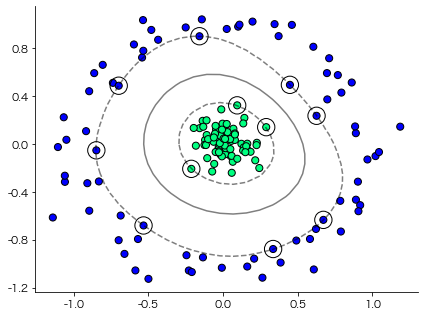

In [36]:
ax = plt.subplots(figsize=(6,4.5))[1]
ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='winter', ec='k')
plot_svc_decision_function(clf, ax)
plt.scatter(clf.support_vectors_[:, 0], 
            clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')
plt.tight_layout()

In [37]:
ax = interact(plot_3D, X=fixed(X), y=fixed(y), model=fixed(clf))

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-30), IntSlider(value=30, descriptio…

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.
This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

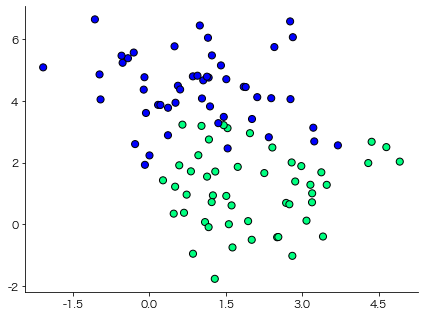

In [38]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
ax = plot_scatter(X, y)

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

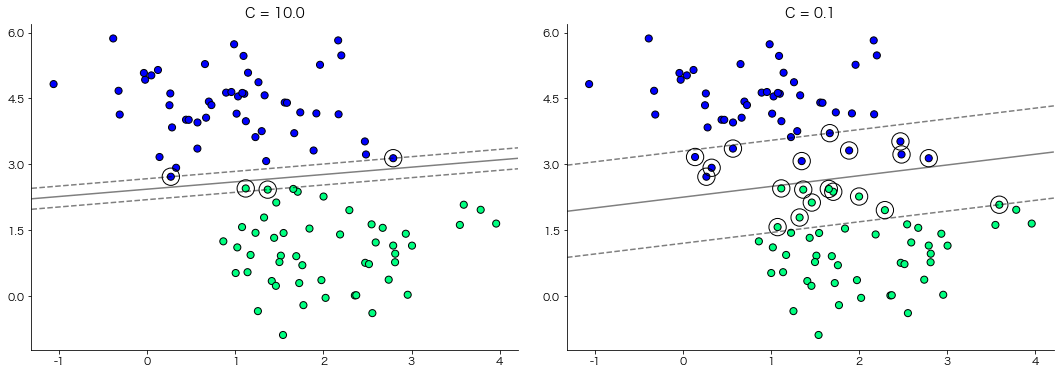

In [39]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="winter", ec='k')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

## Appendix

Support vectors: $\boxed{y_{i}(\vec{w}.\vec{x} + b) \geq 1}$
- Positive sample, $\vec{x}_{pos}\vert y = 1$: $\vec{w}.\vec{x} + b \geq 1$
- Negative sample, $\vec{x}_{neg}\vert y =-1$: $\vec{w}.\vec{x} + b \leq -1$
- $y_{i}(\vec{w}.\vec{x} + b) \geq 1$

Decision boundary: $\vec{w}.\vec{x} + b = 0$

$\vec{w}.\vec{x} = w_{1}x_{1} + w_{2}x_{2} + \ldots +  w_{p}x_{p}$, where $p$ is number of parameters

width: $\boxed{w = \frac{2}{\Vert\vec{w}\Vert}}$
- $w = (\vec{x}_{pos} - \vec{x}_{neg}). \frac{\vec{w}}{\Vert\vec{w}\Vert}$
- $w = (\vec{x}_{pos}.\vec{w} - \vec{x}_{neg}.\vec{w}). \frac{1}{\Vert\vec{w}\Vert}$
- $w = (1 - b + 1 + b). \frac{1}{\Vert\vec{w}\Vert}$
- $w = \frac{2}{\Vert\vec{w}\Vert}$

### Case 1: Perfect separation (Primal form)

Objective: max $\frac{2}{\Vert\vec{w}\Vert}\Longrightarrow$ min $\frac{1}{2}\Vert\vec{w}\Vert^{2}$ 

Subject to: $y_{i}(\vec{w}.\vec{x}_{i} + b) \geq 1$, $\forall$ $i = 1, \ldots, N$

$L(w,b,\lambda) = \frac{1}{2}\Vert\vec{w}\Vert^{2} - \sum\lambda_{i} [ y_{i}(\vec{w}.\vec{x}_{i} + b)-1 ] $, $\lambda_{i}\geq0$

where $\lambda_{i}$ is the associated Lagrange multiplier to $i$.

- $\frac{dL}{dw} = \vec{w} - \sum\lambda_{i}y_{i}\vec{x}_{i} = 0$, thus $\boxed{\vec{w} = \sum\lambda_{i}y_{i}\vec{x}_{i}}$

- $\frac{dL}{db} = - \sum\lambda_{i}y_{i} = 0$, thus $\boxed{\sum\lambda_{i}y_{i} = 0}$

- $L = \frac{1}{2}(\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - (\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - \sum\lambda_{i}y_{i}b + \sum\lambda_{i}$

- $L = \frac{1}{2}(\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - (\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) + \sum\lambda_{i}$

- $\boxed{L = \sum_{i=1}^{N}\lambda_{i} - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}y_{i}y_{j} \vec{x}_{i}.\vec{x}_{j}}$

The optimization depends on the product of pairs of samples i.e. $\vec{x}_{i}.\vec{x}_{j}$. The training examples for which $\lambda_{i}>0$ are called support vectors, because other examples with $\lambda_{i}=0$ can be omitted from the expression.

Thus the dual optimization problem is

Objective: max $L(\lambda) = \sum\lambda_{i} - \frac{1}{2}\sum_{i}\sum_{j}\lambda_{i}\lambda_{j}y_{i}y_{j} \vec{x}_{i}.\vec{x}_{j} = $ $\boxed{\lambda^{T}1 - \frac{1}{2}\lambda^{T}D\lambda}$

Subject to: $\lambda\geq0$, and $\lambda^{T}y=0$

where $y = [y_{1},\ldots,y_{n}]^{T}$ and $D$ is a symmetric $NxN$ matrix with entries $\boxed{D_{i,j} = y_{i}y_{j}x_{i}^{T}.x_{j}}$

The zero KKT-gap requirement (also called the complementary slackness condition) implies that

$\lambda_{i}[y_{i}(x_{i}^{T}.w + b)-1]=0, \forall$ $i=1,\ldots,N$

Therefore, for all support vectors the constraints are active with equality. The bias $b$ can thus be calculated as $\boxed{b = y_{i} − x_{i}^{T}.w}$

using any support vector $x_{i}$. With $\lambda$ and $b$ calculated, the SVM decision function can be represented as $\boxed{c(x) = sgn\left(\sum_{i=1}^{N}y_{i}\lambda_{i}x^{T}x_{i}+b\right)}$

### Case 2: Non-perfect separation (Primal form)

Objective: min $\frac{1}{2}\Vert\vec{w}\Vert^{2} + C\sum\xi$ 

Subject to: $y_{i}(\vec{w}.\vec{x}_{i} + b) \geq 1 - \xi_{i}$, $\forall$ $i = 1, \ldots, N$, and $\xi_{i}\geq 0 ,\forall$ $i$

- $C\longrightarrow0$: Less complex boundary (underfitting)
- $C\longrightarrow\infty$: More complex boundary (overfitting)

$L(w,b,\lambda) = \frac{1}{2}\Vert\vec{w}\Vert^{2} + C\sum\xi_{i} - \sum\lambda_{i} [ y_{i}(\vec{w}.\vec{x}_{i} + b)-1+\xi_{i} ] - \sum\gamma_{i}\xi_{i} $, $\lambda_{i}\geq0, \gamma_{i}\geq0$

where $\lambda_{i}$, and $\gamma_{i}$ are the associated Lagrange multiplier to $i$.

- $\frac{dL}{dw} = \vec{w} - \sum\lambda_{i}y_{i}\vec{x}_{i} = 0$, thus $\boxed{\vec{w} = \sum\lambda_{i}y_{i}\vec{x}_{i}}$

- $\frac{dL}{db} = - \sum\lambda_{i}y_{i} = 0$, thus $\boxed{\sum\lambda_{i}y_{i} = 0}$

- $\frac{dL}{d\xi} = \boxed{C - \lambda_{i} - \gamma_{i}=0,\forall i}$

- $L = \frac{1}{2}(\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) + C\sum\xi_{i} - (\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - \sum\lambda_{i}y_{i}b + \sum\lambda_{i} - \sum\lambda_{i}\xi_{i} - \sum\gamma_{i}\xi_{i} $

- $L = \frac{1}{2}(\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - (\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) + \sum\lambda_{i} + C\sum\xi_{i} - \sum\lambda_{i}\xi_{i} - \sum\gamma_{i}\xi_{i}$

- $L = \frac{1}{2}(\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) - (\sum\lambda_{i}y_{i}\vec{x}_{i})(\sum\lambda_{j}y_{j}\vec{x}_{j}) + \sum\lambda_{i} + \sum \xi_{i}(C - \lambda_{i} - \gamma_{i})$

- $\boxed{L = \sum_{i=1}^{N}\lambda_{i} - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\lambda_{i}\lambda_{j}y_{i}y_{j} \vec{x}_{i}.\vec{x}_{j}}$

Thus the dual optimization problem is

Objective: max $L(\lambda) = \sum\lambda_{i} - \frac{1}{2}\sum_{i}\sum_{j}\lambda_{i}\lambda_{j}y_{i}y_{j} \vec{x}_{i}.\vec{x}_{j} = $ $\boxed{\lambda^{T}1 - \frac{1}{2}\lambda^{T}D\lambda}$

Subject to: $\lambda\geq0$, $\lambda^{T}y=0$, and $\lambda\geq C\bf{1}$

The complementary slackness condition requires

$\lambda_{i}[y_{i}(x_{i}^{T}.w + b)-1+\xi_{i}]=0, \forall$ $i=1,\ldots,N$

$\gamma_{i}\xi_{i}=0, \forall$ $i=1,\ldots,N$

For all support vectors, we can solve $\boxed{b = y_{i} − x_{i}^{T}.w}$ for any support vector $x_{i}$ with $0<\lambda_{i} <C$. 

using any support vector $x_{i}$. With $\lambda$ and $b$ calculated, the SVM decision function can be represented as $\boxed{c(x) = sgn\left(\sum_{i=1}^{N}y_{i}\lambda_{i}x^{T}x_{i}+b\right)}$

- The samples with $\lambda_{i}\ne0$ contribute to the final solution $w$
- In the case of $\xi_{i}=0$ with $y_{i}(x^{T}_{i}.w + b) > 1$, $\gamma_{i}=0$, and $\lambda_{i}=0$ (correctly classified).
- In the case of $\xi_{i}=0$ with $y_{i}(x^{T}_{i}.w + b) = 1$, $0\leq \gamma_{i} < C$, and $0< \lambda_{i} \leq C$, which are governed by $C - \lambda_{i} - \gamma_{i}=0$ (support vector).
- In the case of $\xi_{i}>0$ with $y_{i}(x^{T}_{i}.w + b) = 1 - \xi_{i}$, $\gamma_{i}=0$, and $\lambda_{i}=C$ (misclassified).

### Kernel trick

Using the kernel trick, the optimization problem for SVMs becomes 

max $\lambda^{T}1 - \frac{1}{2}\lambda^{T}D\lambda$

s.t. $\lambda\geq0$, $\lambda^{T}y=0$, and $\lambda\geq C\bf{1}$


where the entries of $D$ are $D_{i,j} = y_{i}y_{j}K(x_{i}^{T}.x_{j})$. The solution for the SVM classifier is formulated as

$\boxed{c(x) = sgn \left(\sum_{i=1}^{N}y_{i}\lambda_{i}K(x_{i},x)+b\right)}$

In [40]:
X, y = make_blobs(n_samples   = 400, 
                  n_features  = 2, 
                  centers     = 4, 
                  cluster_std = [2, 1.5, 1.5, 2], 
                  center_box  = (-10, 10), 
                  random_state= 200)

X = pd.DataFrame(X, columns=['feature_{}'.format(str(n).zfill(2)) 
                             for n in range(1,X.shape[1]+1)])

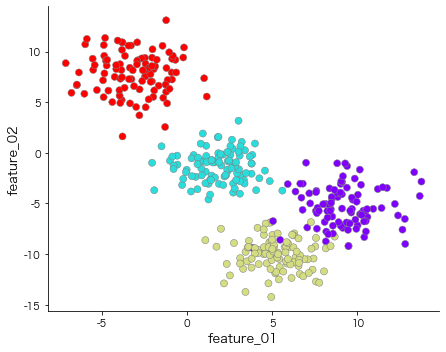

In [41]:
ax = plt.subplots(figsize=(6.3,5))[1]
ax.scatter(X["feature_01"], X["feature_02"],
           edgecolor="grey", lw=0.5, 
           s=50, c=y, cmap="rainbow")
ax.set_xlabel("feature_01", fontsize=13)
ax.set_ylabel("feature_02", fontsize=13)
for s in ["right","top"]: ax.spines[s].set_visible(False)
plt.tight_layout()
plt.show()

In [42]:
clf = SVC(kernel="rbf", decision_function_shape="ovo").fit(X, y)

The kernel function can be any of the following:

- linear: $(x,x^{'})$
- polynomial: $(\gamma(x,x^{'}) + r)^{d}$, where $d$ is specified by parameter `degree`, $r$ by `coef0`.
- rbf (radial basis function): $exp(-\gamma\Vert x-x^{'}\Vert^{2})$, where $\gamma$ is specified by parameter gamma, must be greater than 0.
- sigmoid: $tanh(\gamma(x,x^{'}) + r)$, where `r` is specified by `coef0`.

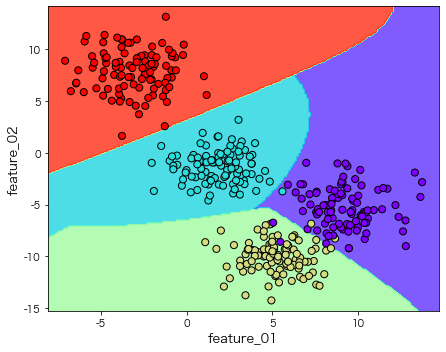

In [43]:
ax = plt.subplots(figsize=(6.3, 5))[1]
n_grids = (200, 200)
x1, x2 = X["feature_01"].values, X["feature_02"].values
ax.scatter(x1, x2, c=y, edgecolor="k", cmap="rainbow", s=50)
    
# Create the grid for background colors
m1 = np.linspace(min(x1)-1, max(x1)+1, n_grids[0]+1)
m2 = np.linspace(min(x2)-1, max(x2)+1, n_grids[1]+1)
m1, m2 = np.meshgrid(m1, m2)
m12 = np.c_[m1.ravel(), m2.ravel()]

# plot decision boundaries (contour)
Z = clf.predict(m12).reshape(m1.shape)
ax.contourf(m1, m2, Z, cmap="rainbow", alpha=0.8, zorder=-10)

ax.set_xlabel("feature_01", fontsize=13)
ax.set_ylabel("feature_02", fontsize=13)
plt.tight_layout()
plt.show()

The prediction is $\boxed{\sum_{i \in SV} y_{i}\alpha_{i}K(x_{i},x) + b}$. These parameters can be accessed through the attributes `dual_coef_` which holds the product $y_{i}\alpha_{i}$, `support_vectors_` which holds the support vectors, and `intercept_` which holds the independent term $b$.

## SVC (decision_function_shape = `ovo`, kernel = `rbf`)

In [44]:
n = np.random.randint(len(X))
xi = X.values[n,:]
n_labels = len(np.unique(y))

# Combination of labels and corresponding decision.
combi = list(combinations(range(n_labels),2))
decsn = clf.decision_function(X.iloc[[n],:]).ravel()
             
# Output
print("Output from SVC")
print("="*30)
print("True class :", y[n])
print("-"*30)
r_classes = []
for p,v in zip(combi,decsn):
    pred = p[0] if v >= 0 else p[1]
    print("{}: {:+,.4f}".format(p,v) + f" --> {pred}")
    r_classes += [pred]
unq,cnt = np.unique(r_classes, return_counts=True)
print("-"*30)
print("Majority vote :",unq[np.argmax(cnt)] )
print("Prediction :", int(clf.predict(X.iloc[[n],:])))
print("="*30)

Output from SVC
True class : 1
------------------------------
(0, 1): -1.5540 --> 1
(0, 2): +0.4583 --> 0
(0, 3): +0.1177 --> 0
(1, 2): +1.7653 --> 1
(1, 3): +1.6664 --> 1
(2, 3): -0.1287 --> 3
------------------------------
Majority vote : 1
Prediction : 1


In [45]:
# Manual calculation
results = dict()
SV = clf.support_vectors_
gamma = clf._gamma
intercepts = clf.intercept_

# Support vectors indices
sv_indices = np.r_[0, np.cumsum(clf.n_support_)]

for k in range(n_labels):

    # Starting and ending indices
    start, end = sv_indices[k], sv_indices[k+1]
    
    # Coefficients (w) for all support vectors, of shape (n_labels-1,)
    coefs = [clf.dual_coef_[c][start:end] for c in range(n_labels-1)]
    
    # Number of support vectors given class `k`
    n_coefs = end - start
    
    vs = [n for n in range(n_labels) if n!=k]
    diff = SV[start:end,:] - xi
    
    for p,icoefs in enumerate(coefs):
        decision = 0
        for i in range(n_coefs):
            t = diff[i,:]
            decision += icoefs[i] * np.exp(-gamma*(t.dot(t))) 
        results["{}-{}".format(k,vs[p])] = decision
        
print("Manual calculation")
print("="*30)
for (i,j),b0 in zip(combi,intercepts):
    desc = results["{}-{}".format(i,j)] + results["{}-{}".format(j,i)] + b0
    print("({}, {}): {:+,.4f}".format(i,j,desc))
print("="*30)

Manual calculation
(0, 1): -1.5540
(0, 2): +0.4583
(0, 3): +0.1177
(1, 2): +1.7653
(1, 3): +1.6664
(2, 3): -0.1287


## One-class SVM

One-class SVM proposed by Scholkopf et al. (2001) for estimating the support of a high-dimensional distribution. Given training vectors $x_{i} \in R^{n}, i = 1, \ldots,l$ without any class information, the primal problem of one-class SVM is

> Objective: min $\frac{1}{2}\bf{w}^{T}\bf{w} - \rho + \frac{1}{\nu l}\sum_{i=1}^{l}\xi_{i}$

> Subject to: $\bf{w}^{T}\phi(x_{i})\geq\rho-\xi_{i}, \xi_{i}\geq0, i = 1,\ldots,l$

The dual problem is

> Objective: min $\frac{1}{2}\alpha^{T}Q\alpha$

> Subject to: $0\leq\alpha_{i}\leq\frac{1}{\nu l}, i = 1,\ldots,l$, $\bf{e}^{T}\bf{\alpha} = 1$

where $\bf{e} = [1,\ldots,1]^{T}$ is the vector of all ones, and $Q_{i,j}= K(x_{i},x_{j}) = \phi(x_{i})^{T}\phi(x_{j}).$ The decision function is

> $f(x) = sgn \left( \sum_{i=1}^{l} \alpha_{i}K(x_{i},x) - \rho \right)$

The `decision_function` in `sklearn` is 

> $c(x) = \sum_{i \in SV} \alpha_{i}K(x_{i},x) + b$ or $\sum_{i \in SV} \alpha_{i}K(x_{i},x) - \rho$. 

These parameters can be accessed through the attributes `dual_coef_` which holds  holds the product $\alpha_{i}$, `support_vectors_` which holds the support vectors, `intercept_` which holds the independent term $b$, and  `offest_` which holds the independent term $\rho$.

In [46]:
X = make_blobs(n_samples   = 100, 
               n_features  = 2, 
               centers     = 2, 
               cluster_std = [1, 1.5], 
               center_box  = (-10, 10), 
               random_state= 100)[0]

OCSVM = OneClassSVM(nu=0.12, kernel="rbf", gamma=0.1).fit(X)

In [47]:
n = np.random.randint(len(X))
xi = X[[n],:]
scr = OCSVM.score_samples(xi)[0]
desc = OCSVM.decision_function(xi)[0]
pred = OCSVM.predict(xi)[0]
print("Output from OneClassSVM")
print("="*30)
print("Score: {:,.4f}".format(scr))
print("Offset: {:,.4f}".format(OCSVM.offset_[0]))
print("Decision function: {:,.4f}".format(desc))
print("Prediction: {:d}".format(pred))
print("="*30)

Output from OneClassSVM
Score: 2.4347
Offset: 2.2225
Decision function: 0.2122
Prediction: 1


In [48]:
diff = OCSVM.support_vectors_ - xi
score = sum([coef * np.exp(-OCSVM._gamma*(diff[n,:].dot(diff[n,:]))) 
             for n,coef in enumerate(OCSVM.dual_coef_.ravel())])
print("Manual calculation")
print("="*30)
print("Score: {:,.4f}".format(score))
print("Decision function: {:,.4f}".format(score+OCSVM.intercept_[0]))
print("="*30)

Manual calculation
Score: 2.4347
Decision function: 0.2122


% Outlier: 12%
Ratio (n_outliers/n_supports): 80%


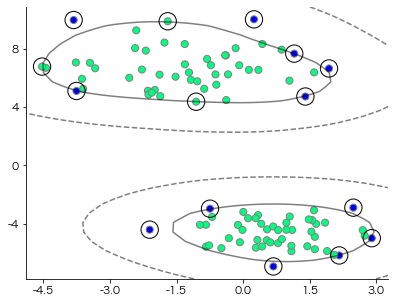

In [49]:
fig, ax = plt.subplots(figsize=(6.5,5))
ax.scatter(X[:,0], X[:,1], c=OCSVM.predict(X), s=50, cmap="winter", ec="grey")
plot_svc_decision_function(OCSVM, ax) 
desc_SVs = OCSVM.decision_function(OCSVM.support_vectors_)
print("% Outlier: {:.0%}".format(np.mean(OCSVM.predict(X)<0)))
print("Ratio (n_outliers/n_supports): {:.0%}".format(np.mean(desc_SVs<0)))

In [50]:
df = pd.DataFrame({"score"  : OCSVM.decision_function(X).ravel(),
                   "outlier": np.where(OCSVM.predict(X).ravel()==-1,1,0)})
df.sort_values(by="score").reset_index(drop=True).head()

,score,outlier
0,-0.296275,1
1,-0.266645,1
2,-0.215579,1
3,-0.164791,1
4,-0.143061,1
